In [1]:
# mute Hardware optimzation messages
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '1'

import tensorflow as tf

In [ ]:
# When using docker tensorflow/tensorflow:latest-juypter
!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org scikit-learn pandas

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Start the coding for logistic regression

<h3>Understanding the Data</h3>

<h4><code>Iris Dataset</code>:</h4>
This dataset was introduced by British Statistician and Biologist Ronald Fisher, it consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). In total it has 150 records under five attributes - petal length, petal width, sepal length, sepal width and species. <a href="https://archive.ics.uci.edu/ml/datasets/iris">Dataset source</a>

Attributes
Independent Variable

<ul>
    <li>petal length</li>
    <li>petal width</li>
    <li>sepal length</li>
    <li>sepal width</li>
</ul>
Dependent Variable
<ul>    
    <li>Species
        <ul>
            <li>Iris setosa</li>
            <li>Iris virginica</li>
            <li>Iris versicolor</li>
        </ul>
    </li>
</ul>
<br>

In [3]:
# Prepare the data and variables
iris = load_iris()
iris_X, iris_y = iris.data[:-1,:], iris.target[:-1]
iris_y = pd.get_dummies(iris_y).values
trainX, testX, trainY, testY = train_test_split(iris_X, iris_y, test_size=0.33, random_state=42)

In [4]:
# numFeatures is teh number of features in the input data
# In the iris dataset, this is 4
numFeatures = trainX.shape[1]
print('numFeatures is: ', numFeatures)
# numLabels is the number of classes our data points can be in
# In the dataset, this is 3
numLabels = trainY.shape[1]
print("numLabels is :", numLabels)

# Via Tensorflow
#X = tf.Variable( np.identity(numFeatures), tf.TensorShape(numFeatures),dtype='float32') # Iris has 4 features, so X is a tensor to hold our data.
#yGold = tf.Variable(np.array([1,1,1]),shape=tf.TensorShape(numLabels),dtype='float32') # This will be our correct answers matrix for 3 classes.

numFeatures is:  4
numLabels is : 3


In [5]:
# Set the train-test data
trainX = tf.constant(trainX, dtype='float32')
trainY = tf.constant(trainY, dtype='float32')
testX = tf.constant(testX, dtype='float32')
testY = tf.constant(testY, dtype='float32')

In [7]:
# Initialise the model weights and bias for training
W = tf.Variable(tf.zeros([4,3])) # 4-Dimensional input and 3 classes
b = tf.Variable(tf.zeros([3])) # 3-Dimensional output [0,0,1],[0,1,0],[1,0,0]

In [8]:
# Randomly sample from a normal distribution with standard deviation at 0.01
weights = tf.Variable(tf.random.normal([numFeatures, numLabels],
                                       mean=0.0,
                                       stddev=0.01,
                                       name='weights'),
                      dtype='float32')
bias = tf.Variable(tf.random.normal([1,numLabels],
                                    mean=0.0,
                                    stddev=0.01,
                                    name="bias"))

### Logistic Regression Model
This is typically summarized/described as a sigmoid equation
$$
ŷ =sigmoid(WX+b)
$$
where it is composed of:
-   a weight times features matrix multiplication operation, 
-   a summation of the weighted features and a bias term, 
-   and finally the application of a sigmoid function. 

In [10]:
# Three-component breakdown of the Logistic Regression Equation
# Note that these feed into each other
def logistic_regression(x):
    apply_weights_OP = tf.matmul(x, weights, name="apply_weights")
    add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias")
    # The activation_OP effectively 'fits' the dataset within a normalzed 0-100 percent
    activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")
    return activation_OP


### Training the Model

#### Cost Function
Defines the learning rate and for how long the training should take

In [11]:
# Number of Epochs in our training
numEpochs = 700

# Defining our learning rate iterations (decay)
learningRate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0008,
    decay_steps=trainX.shape[0],
    decay_rate=0.95,
    staircase=True)

The cost function utilized is the _Squared Mean Error_ loss function. As the least-squares linear regression cannot be used, _batch gradient descent_ is used instead.

In [12]:
# Defining the cost function - Squared Mean Error
loss_object = tf.keras.losses.MeanSquaredLogarithmicError()
optimizer = tf.keras.optimizers.SGD(learningRate)

#### Accuracy and Efficiency

In [13]:
# Accuracy metric to track model efficiency over time
def accuracy(y_pred, y_true):
    # Predicted class is the index of the highest score in prediction vector (i.e. argmax)
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

For automatic differentiation, computation is wrapped inside a *GradientTape*. It is then computed for the gradients as well as any updates to *W* and *b*.

In [15]:
# Optimization process
def run_optimization(x,y):
    with tf.GradientTape() as g:
        pred = logistic_regression(x)
        loss = loss_object(pred, y)
    gradients = g.gradient(loss, [weights, bias])
    optimizer.apply_gradients(zip(gradients, [weights, bias]))

#### Running the Model

In [16]:
# initialize the reporting variables
display_step = 10
epoch_values = []
accuracy_values = []
loss_values = []
loss = 0
diff = 1

In [17]:
# Training Epochs
for i in range(numEpochs):
    if i > 1 and diff < 0.0001:
        print("change in loss %g; convergence."%diff)
        break
    else:
        # Run training step
        run_optimization(trainX, trainY)

        # Report occassional stats
        if i % display_step == 0:
            epoch_values.append(i)

            pred = logistic_regression(testX)

            newLoss = loss_object(pred, testY)
            # Add loss to live graphing variable
            loss_values.append(newLoss)

            # Generate accuracy stats on test data
            acc = accuracy(pred, testY)
            accuracy_values.append(acc)

            # Re-assign values for variables
            diff = abs(newLoss - loss)
            loss = newLoss

            # Generate print statements
            print("step %d, training accuracy %g, loss %g, change in loss %g"%(i, acc, newLoss, diff))

print("final accuracy on test set: %s" %acc.numpy())    

step 0, training accuracy 0.32, loss 0.135932, change in loss 0.135932
step 10, training accuracy 0.32, loss 0.135335, change in loss 0.000596359
step 20, training accuracy 0.32, loss 0.134747, change in loss 0.00058794
step 30, training accuracy 0.32, loss 0.134168, change in loss 0.000579551
step 40, training accuracy 0.32, loss 0.133597, change in loss 0.000571117
step 50, training accuracy 0.32, loss 0.133034, change in loss 0.000562698
step 60, training accuracy 0.32, loss 0.13248, change in loss 0.000554293
step 70, training accuracy 0.32, loss 0.131934, change in loss 0.000545904
step 80, training accuracy 0.32, loss 0.131396, change in loss 0.000537515
step 90, training accuracy 0.32, loss 0.130867, change in loss 0.00052917
step 100, training accuracy 0.32, loss 0.130351, change in loss 0.000515684
step 110, training accuracy 0.32, loss 0.129864, change in loss 0.000487223
step 120, training accuracy 0.32, loss 0.129384, change in loss 0.000479773
step 130, training accuracy 0

#### Plotting the change in loss throughout training

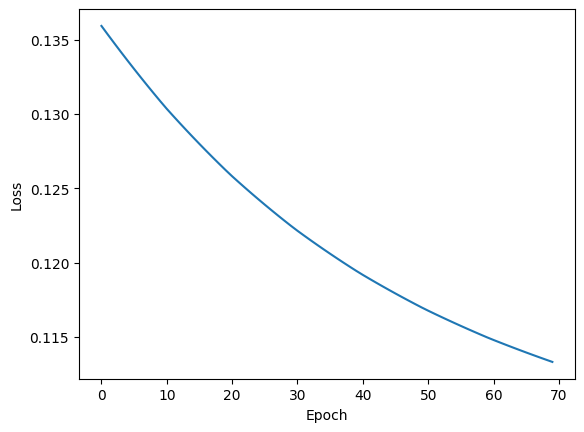

In [18]:
%matplotlib inline
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_values)
plt.show()